<a href="https://colab.research.google.com/github/Mainakdeb/eyes-on-the-road/blob/master/train-motor-sentinel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
from tqdm.notebook import tnrange, tqdm
import torch
import torchvision
from torch.utils.data import Dataset, TensorDataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from PIL import Image

In [5]:
torch.cuda.is_available()

True

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Unzip the training data into runtime storage from Google Drive :

In [0]:
%%bash 
mkdir foldername
tar -xvf '/content/drive/My Drive/train.tar.xz' -C '/content/'

In [0]:
def image_to_nparray(path):
    i = plt.imread(path)    
    return(np.array(i))


## A Custom class for this dataset:




In [0]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv_file_path, root_dir, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = pd.read_csv(csv_file_path, header= None)[1:]
    

        
    def __getitem__(self, idx): 

        smol_img_path = str(self.d.iloc[idx][3])
        class_name = str(self.d.iloc[idx][2])[-1] 
        full_img_path = self.root_dir + '/' + 'c'+ class_name + '/' + smol_img_path
        img_arr = image_to_nparray(full_img_path)

        if self.transform is not None:
            img_arr = self.transform(img_arr)
        
        return  img_arr, torch.tensor(int(class_name))
        
        

    def __len__(self):
      
        return (len(self.d))

## Custom class for adding Gausian noise :


In [0]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [0]:
data = C_Dataset('/content/drive/My Drive/balanced.csv', 
               '/content/train/',
                transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224), interpolation=2),
                                                transforms.RandomRotation(20),
                                                transforms.RandomPerspective(distortion_scale=0.1, p=0.5, interpolation=3, fill=0),
                                                transforms.ToTensor(),
                                                #AddGaussianNoise(0., 0.05)
                                                ])
                )


val_data = C_Dataset('/content/drive/My Drive/val.csv', 
               '/content/train/',
                transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224), interpolation=2),
                                                #transforms.RandomRotation(10),
                                                transforms.ToTensor(),
                                                #AddGaussianNoise(0., 0.5)
                                                ])
                )

train_set, val_set = data, val_data

print(len(train_set), len(val_set))

## Plot Augmented Samples from the Train-Loader :


In [0]:
train_loader_1 = torch.utils.data.DataLoader(
    train_set
    ,batch_size=10
    ,shuffle=True
)

class_list = ['safe', 'text-R', 'talk on phone-R', 'text-L', 'talk on phone-L', 'radio', 'drink'
, 'reach behind', 'hair/make-up', 'talk to passenger']
fig, axs = plt.subplots(5, 5, figsize=(17,17))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(5):
    for j in range(5):
        for images, labels in (train_loader_1):
            
            x=np.transpose(images[0], (1, 2, 0))  
            class_number = labels[0].item()
            im_label=class_list[class_number]
            axs[j,i].imshow(x, interpolation='none')
            axs[j,i].title.set_text(im_label)
            break
plt.show()

## A function to compute the number of correct predictions :


In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

## A function to plot the training metrics :

In [0]:
def plot_metric(arg, frm):
    
    if (arg)=='loss':
        a,b = loss_list, val_loss_list
    elif (arg)=='accuracy':
        a,b=acc_list, val_acc_list
            
    width_height = (11,3)
    plt.figure(figsize=width_height)

    #plt.axvspan(11,13, color='red', alpha=0.2)
    
    plt.plot(a[frm:], label='Training ' + str(arg))
    plt.plot(b[frm:], label='Validation ' + str(arg))
    plt.xlabel(str(arg))
    plt.ylabel("Epochs")
    plt.grid()
    plt.legend()
    plt.show()

## The Model :

In [120]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*34*34, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 2)

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        print(x.shape)
        x = x.view(-1, 16*34*34)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

        

network = model_ft.to(device)
print(network)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
batch_size=32
learning_rate = 0.0002


train_loader_2 = torch.utils.data.DataLoader(
    train_set
    ,batch_size=batch_size
    ,shuffle=True

)

val_loader = torch.utils.data.DataLoader(
    val_set, 
    batch_size=batch_size, 
    shuffle=True,
)

loss_list=[]
acc_list=[]
val_loss_list=[]
val_acc_list=[]


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #lr=0.00003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4)

## Training Loop :

In [143]:
for epoch in tnrange(1):
  
    total_loss = 0
    total_correct = 0
    total_loss2 = 0
    total_correct2 = 0
    
    
    with torch.no_grad():
        network.eval()
        for batch2 in (val_loader): # Get Batch

            images2, labels2 = batch2
            images2=images2.to(device)
            labels2=labels2.to(device)

            preds2 = network(images2) # Pass Batch
        
            loss2 = F.cross_entropy(preds2, labels2)
            
            total_loss2 += loss2.item()
            total_correct2 += get_num_correct(preds2, labels2)

    for batch in tqdm(train_loader_2): # Get Batch

        optimizer.zero_grad()
        images, labels = batch
        images=images.to(device)
        labels=labels.to(device)

        preds = network(images)
        
        loss = F.cross_entropy(preds, labels)
        loss.backward() # Calculate Gradients
        optimizer.step()  
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
            

    loss_list.append(total_loss/(len(train_set)))
    acc_list.append(total_correct/(len(train_set)))
    val_loss_list.append(total_loss2/(len(val_set)))
    val_acc_list.append(total_correct2/(len(val_set)))

## The Metrics :

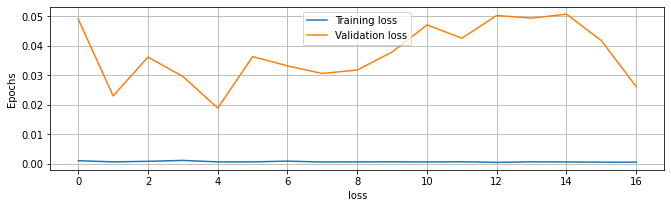

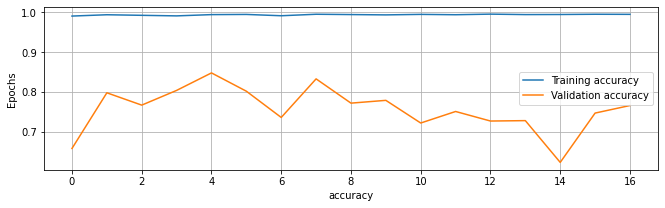

In [144]:
plot_metric('loss', 0)
plot_metric('accuracy', 0)

In [141]:
print("Accuracy:", max(val_acc_list)*100, "%")

Accuracy: 84.8 %


In [0]:
torch.save(network.state_dict(), 'model_custom.pt') 

## To do:
* ~~train the nn~~
* use pytorch-lr-finder